# How was the wheater during session in WUT?

We define exam session time as first two full weeks of Feburary (i.e. first day of session is first monday of Februray) and last two weeks of June (i.e. last day of session is last sunday of June).

## Instalation of libraries

In [62]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

## Defining libraries and client config

In [63]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

import datetime

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
def get_special_dates(year: int) -> tuple[tuple[str, str], tuple[str, str]]:
    def get_first_full_week_of_february(year):
        # Find the first Monday of February
        february_first = datetime.date(year, 2, 1)
        first_monday = february_first + datetime.timedelta(days=(7 - february_first.weekday()) % 7)
        # Get the start and end of the first full week
        start_date = first_monday
        end_date = first_monday + datetime.timedelta(days=13)
        return start_date, end_date

    def get_last_two_full_weeks_of_june(year):
# Find the first day of July
        july_first = datetime.date(year, 7, 1)
        # Find the last Sunday that is in June
        last_sunday_in_june = july_first - datetime.timedelta(days=july_first.weekday() + 1)
        # Calculate the start of the last two full weeks
        last_week_start = last_sunday_in_june - datetime.timedelta(days=6)
        second_last_week_start = last_week_start - datetime.timedelta(days=7)
        second_last_week_end = second_last_week_start + datetime.timedelta(days=6)
        return second_last_week_start, second_last_week_end, last_week_start, last_sunday_in_june
    
    feb_start, feb_end = get_first_full_week_of_february(year)
    june_2nd_last_start, june_2nd_last_end, june_last_start, june_last_end = get_last_two_full_weeks_of_june(year)
    
    return (feb_start.strftime("%Y-%m-%d"), feb_end.strftime("%Y-%m-%d")), (june_2nd_last_start.strftime("%Y-%m-%d"), june_last_end.strftime("%Y-%m-%d"))

In [65]:
def get_weather_in_mini_between_dates(client: openmeteo_requests.Client, dates: tuple[str, str]) -> pd.DataFrame:
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 52.22,
        "longitude": 21,
        "start_date": dates[0],
        "end_date": dates[1],
        "daily": ["daylight_duration", "sunshine_duration"],
        "timezone": "Europe/Berlin"
    }
    responses = client.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_daylight_duration = daily.Variables(0).ValuesAsNumpy()
    daily_sunshine_duration = daily.Variables(1).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}
    daily_data["daylight_duration"] = daily_daylight_duration
    daily_data["sunshine_duration"] = daily_sunshine_duration

    # Calculate the percentage
    daily_data['percentage_sunshine'] = (daily_data['sunshine_duration'] / daily_data['daylight_duration']) * 100

    return pd.DataFrame(data = daily_data)

In [66]:
df = pd.DataFrame()
df_lato = pd.DataFrame()
df_zima = pd.DataFrame()
for i in range(1999, 2023):
    dates = get_special_dates(i)
    print("First full week of February:", dates[0])
    print("Last two full weeks of June ending in July:", dates[1])
    daily_dataframe = get_weather_in_mini_between_dates(openmeteo, dates[0])
        # Counting days with 90% and above, and 10% and below
    df = pd.concat([df, daily_dataframe], ignore_index=True)
    df_zima = pd.concat([df_zima, daily_dataframe], ignore_index=True)
    print(daily_dataframe)
    daily_dataframe = get_weather_in_mini_between_dates(openmeteo, dates[1])
            # Counting days with 90% and above, and 10% and below
    df = pd.concat([df, daily_dataframe], ignore_index=True)
    df_lato = pd.concat([df_lato, daily_dataframe], ignore_index=True)
    print(daily_dataframe)

First full week of February: ('1999-02-01', '1999-02-14')
Last two full weeks of June ending in July: ('1999-06-14', '1999-06-27')
Coordinates 52.196834564208984°N 20.922508239746094°E
Elevation 120.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s
                        date  daylight_duration  sunshine_duration  \
0  1999-01-31 22:00:00+00:00       32673.177734         830.752930   
1  1999-02-01 22:00:00+00:00       32882.707031           0.000000   
2  1999-02-02 22:00:00+00:00       33094.578125           0.000000   
3  1999-02-03 22:00:00+00:00       33308.535156           0.000000   
4  1999-02-04 22:00:00+00:00       33524.316406       13822.162109   
5  1999-02-05 22:00:00+00:00       33741.679688       11592.002930   
6  1999-02-06 22:00:00+00:00       33960.390625       21906.115234   
7  1999-02-07 22:00:00+00:00       34180.210938       10779.195312   
8  1999-02-08 22:00:00+00:00       34400.914062       10641.166992   
9  1999-02-09 22:00:00+

# Sum

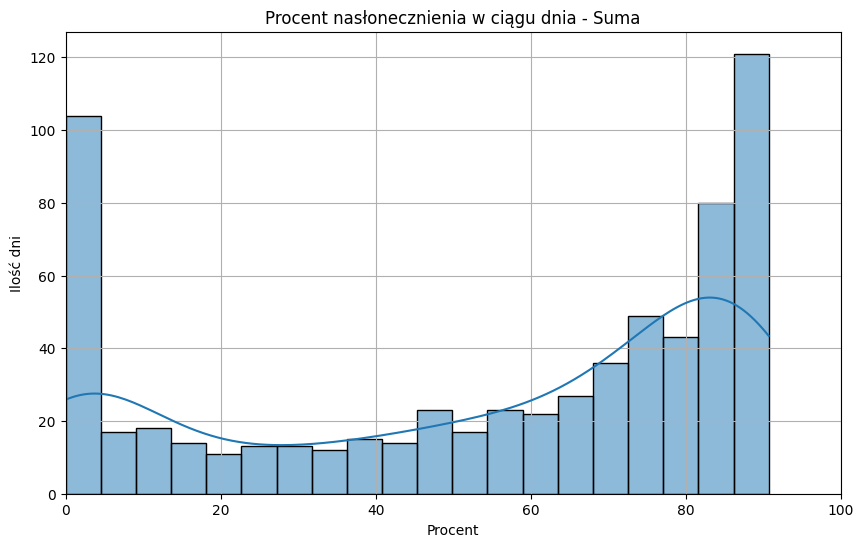

In [77]:
# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['percentage_sunshine'], kde=True, bins=20)
plt.title('Procent nasłonecznienia w ciągu dnia - Suma')
plt.xlabel('Procent')
plt.ylabel('Ilość dni')
plt.xlim(0, 100)  # Set the x-axis limit to ensure values stay within 0 to 100
plt.grid(True)
plt.show()

In [73]:
# Calculate the histogram
counts, bin_edges = np.histogram(df['percentage_sunshine'], bins=20, range=(0, 100))

# Identify the indices of the two highest bins
highest_bin_indices = np.argsort(counts)[-2:][::-1]

# Extract the counts and bin edges for the two highest bins
highest_bins = [(bin_edges[i], bin_edges[i+1], counts[i]) for i in highest_bin_indices]

# Find the bins for the ranges 0-15 and 85-100
bin_edges_0_15 = (0, 15)
bin_edges_85_100 = (85, 100)

# Calculate counts for 0-15 and 85-100 ranges
count_0_15 = counts[(bin_edges[:-1] >= bin_edges_0_15[0]) & (bin_edges[1:] <= bin_edges_0_15[1])].sum()
count_85_100 = counts[(bin_edges[:-1] >= bin_edges_85_100[0]) & (bin_edges[1:] <= bin_edges_85_100[1])].sum()

# Print the counts for the two highest bins
for i, (lower_edge, upper_edge, count) in enumerate(highest_bins):
    print(f"Highest bin {i+1}: {lower_edge} to {upper_edge}, Count: {count}")

# Print the counts for the 0-15 and 85-100 ranges
print(f"Count for 0 to 15: {count_0_15}")
print(f"Count for 85 to 100: {count_85_100}")

Highest bin 1: 85.0 to 90.0, Count: 142
Highest bin 2: 0.0 to 5.0, Count: 106
Count for 0 to 15: 142
Count for 85 to 100: 156


# Winter

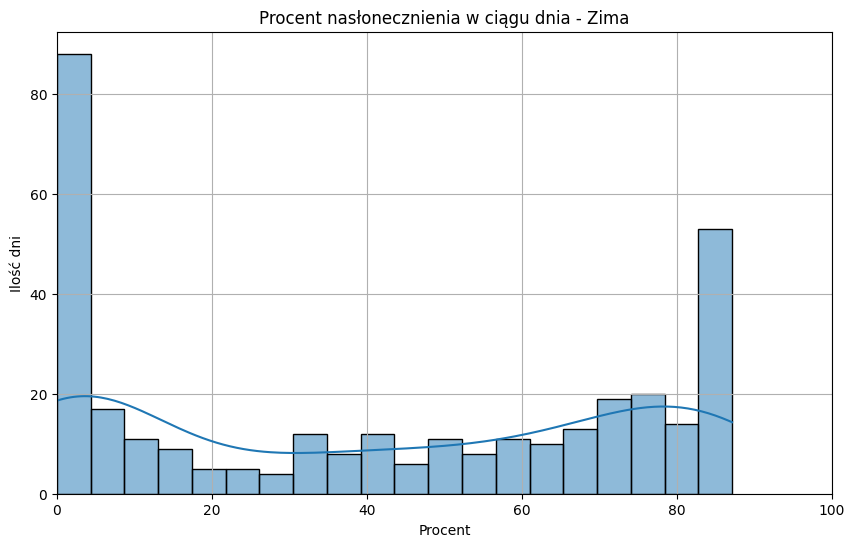

In [78]:
# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_zima['percentage_sunshine'], kde=True, bins=20)
plt.title('Procent nasłonecznienia w ciągu dnia - Zima')
plt.xlabel('Procent')
plt.ylabel('Ilość dni')
plt.xlim(0, 100)  # Set the x-axis limit to ensure values stay within 0 to 100
plt.grid(True)
plt.show()

In [74]:
# Calculate the histogram
counts, bin_edges = np.histogram(df_zima['percentage_sunshine'], bins=20, range=(0, 100))

# Identify the indices of the two highest bins
highest_bin_indices = np.argsort(counts)[-2:][::-1]

# Extract the counts and bin edges for the two highest bins
highest_bins = [(bin_edges[i], bin_edges[i+1], counts[i]) for i in highest_bin_indices]

# Find the bins for the ranges 0-15 and 85-100
bin_edges_0_15 = (0, 15)
bin_edges_85_100 = (85, 100)

# Calculate counts for 0-15 and 85-100 ranges
count_0_15 = counts[(bin_edges[:-1] >= bin_edges_0_15[0]) & (bin_edges[1:] <= bin_edges_0_15[1])].sum()
count_85_100 = counts[(bin_edges[:-1] >= bin_edges_85_100[0]) & (bin_edges[1:] <= bin_edges_85_100[1])].sum()

# Print the counts for the two highest bins
for i, (lower_edge, upper_edge, count) in enumerate(highest_bins):
    print(f"Highest bin {i+1}: {lower_edge} to {upper_edge}, Count: {count}")

# Print the counts for the 0-15 and 85-100 ranges
print(f"Count for 0 to 15: {count_0_15}")
print(f"Count for 85 to 100: {count_85_100}")

Highest bin 1: 0.0 to 5.0, Count: 91
Highest bin 2: 85.0 to 90.0, Count: 39
Count for 0 to 15: 120
Count for 85 to 100: 39


# Summer

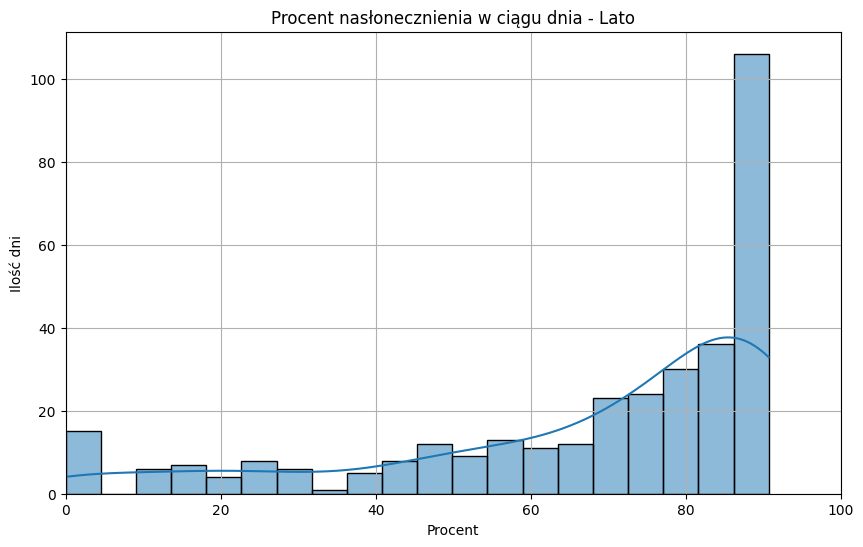

In [79]:
# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_lato['percentage_sunshine'], kde=True, bins=20)
plt.title('Procent nasłonecznienia w ciągu dnia - Lato')
plt.xlabel('Procent')
plt.ylabel('Ilość dni')
plt.xlim(0, 100)  # Set the x-axis limit to ensure values stay within 0 to 100
plt.grid(True)
plt.show()

In [75]:
# Calculate the histogram
counts, bin_edges = np.histogram(df_lato['percentage_sunshine'], bins=20, range=(0, 100))

# Identify the indices of the two highest bins
highest_bin_indices = np.argsort(counts)[-2:][::-1]

# Extract the counts and bin edges for the two highest bins
highest_bins = [(bin_edges[i], bin_edges[i+1], counts[i]) for i in highest_bin_indices]

# Find the bins for the ranges 0-15 and 85-100
bin_edges_0_15 = (0, 15)
bin_edges_85_100 = (85, 100)

# Calculate counts for 0-15 and 85-100 ranges
count_0_15 = counts[(bin_edges[:-1] >= bin_edges_0_15[0]) & (bin_edges[1:] <= bin_edges_0_15[1])].sum()
count_85_100 = counts[(bin_edges[:-1] >= bin_edges_85_100[0]) & (bin_edges[1:] <= bin_edges_85_100[1])].sum()

# Print the counts for the two highest bins
for i, (lower_edge, upper_edge, count) in enumerate(highest_bins):
    print(f"Highest bin {i+1}: {lower_edge} to {upper_edge}, Count: {count}")

# Print the counts for the 0-15 and 85-100 ranges
print(f"Count for 0 to 15: {count_0_15}")
print(f"Count for 85 to 100: {count_85_100}")

Highest bin 1: 85.0 to 90.0, Count: 103
Highest bin 2: 80.0 to 85.0, Count: 37
Count for 0 to 15: 22
Count for 85 to 100: 117
